# Image Processing with Python: Image Differencing for Video Feeds

by: Jephraim C. Manansala | Published on https://jephraim-manansala.medium.com/

### How to detect the changes and movement in video frames?

In this post, we will learn how we can apply the image differencing to detect changes and movement in each frame of a video.

Let’s begin.

As usual, we import libraries such as `numpy` and `matplotlib`. We also import specific functions from the `skimage` library. Lastly, we will introduce the `cv2` library to convert video files to images. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from skimage.color import rgb2gray
from skimage.feature import match_template, peak_local_max
from skimage import transform
import cv2

But first, let us define what **image differencing** is. Basically, it is an image processing technique used to determine changes between images by finding the difference between each pixel in each image. The generated image highlights the pixel values’ changes, while all pixels that have no changes will be zero. The critical point is that the two images must be properly aligned for this technique to work.

Let’s use a traffic surveillance feed from a major highway in Metro Manila, Philippines. *(Video courtesy of GMA News TV, Philippines)*.

To implement image processing techniques on this video file, we will convert a short clip of this surveillance feed into images using the video frames. For this problem, the image’s capture interval will be 5 seconds — to emphasize the difference between images.

In [2]:
vidcap = cv2.VideoCapture('traffic.mp4')
def getFrame(sec):
    vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
    hasFrames,image = vidcap.read()
    if hasFrames:
        cv2.imwrite("traffic_frame"+str(count)+".jpg", image) 
    return hasFrames
sec = 0
frameRate = 5 #capture an image every 5 seconds
count = 1
success = getFrame(sec)
while success:
    count = count + 1
    sec = sec + frameRate
    sec = round(sec, 2)
    success = getFrame(sec)

After converting the image, let’s inspect the image frame

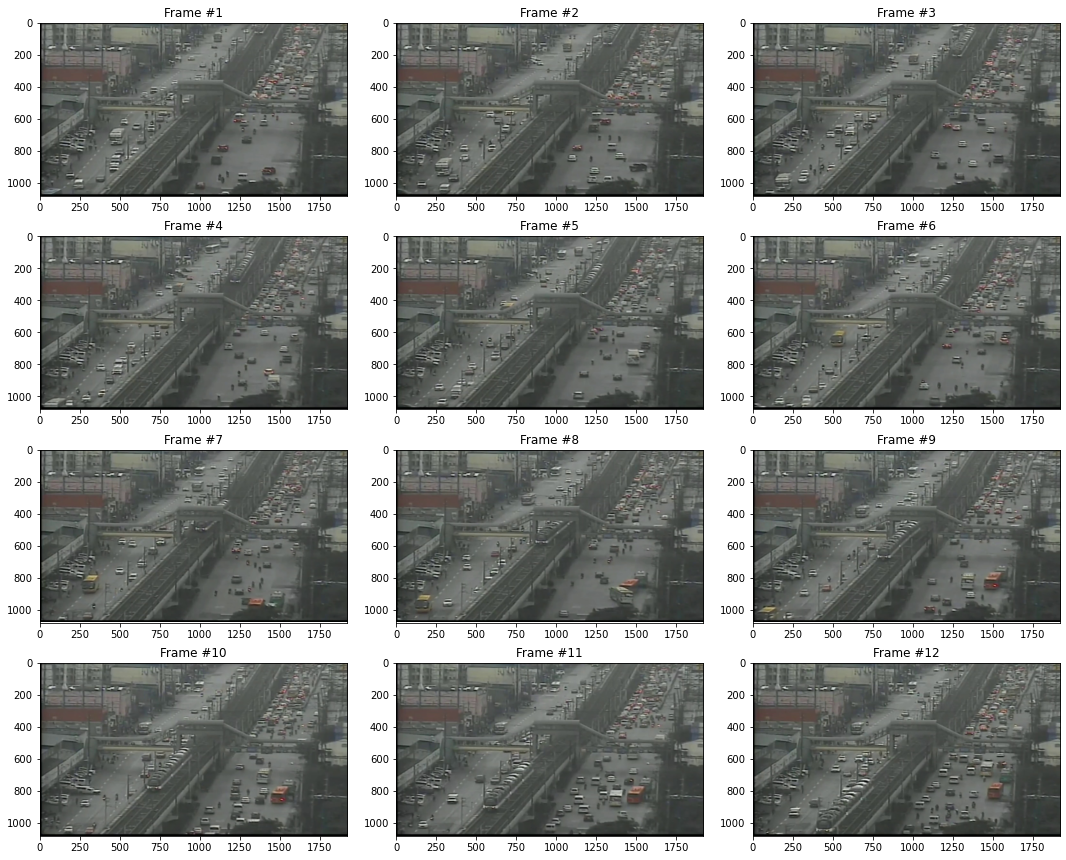

In [3]:
rgb_frames = ['traffic_frame'+str(num) for num in range(1, 15)]
gray_frames = ['traffic_frame'+str(num)+'_gray' for num in range(1, 15)]
images = []
for rgb, gray in zip(rgb_frames, gray_frames): 
    globals()[rgb] = imread(rgb+'.jpg')
    globals()[gray] = rgb2gray(globals()[rgb])
    images.append(globals()[rgb])
    
fig, axis = plt.subplots(4,int(len(images)/4), figsize=(15,12))

i = 1
for im, ax in zip(images, axis.flatten()):
    ax.imshow(im)
    ax.set_title("Frame #{}".format(i))
    i +=1
plt.tight_layout()

*Great!* For ease of our analysis, we will only be using two frames in this example. Let’s use Frame #10 and #12 because this is where the train is the clearest.

Text(0.5, 1.0, 'Frame #12')

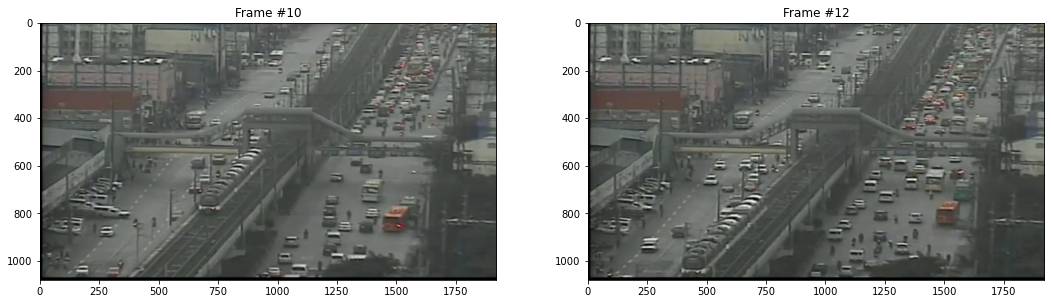

In [4]:
fig, axis = plt.subplots(1,2, figsize=(18,6))

axis[0].imshow(traffic_frame10)
axis[0].set_title('Frame #10')
axis[1].imshow(traffic_frame12)
axis[1].set_title('Frame #12')

Now, let’s apply image processing techniques to prepare our image for image differencing. Since the image is taken at an angle, we can apply the homography matrix to change the image’s perspective. I will no longer discuss how the homography matrix works. If you are not yet familiar with this technique, I suggest reading it in my previous article!


In [5]:
area_of_interest = [(890, 575),
                    (1085, 575),
                    (670, 1030),
                    (440, 1030)]

area_of_projection = [(930, 600),
                      (1070, 600),
                      (1070, 1000),
                      (930, 1000)]

In [6]:
def project_planes(image, src=area_of_interest, 
                   dst=area_of_projection):
    new_image = image.copy() 
    projection = np.zeros_like(new_image)
    tform = transform.estimate_transform('projective', 
                                         np.array(src), 
                                         np.array(dst))
    transformed = transform.warp(image, tform.inverse)
    return transformed

In [7]:
def plot_project_planes(image, transformed, src, dst):
    x_src = [val[0] for val in src] + [src[0][0]]
    y_src = [val[1] for val in src] + [src[0][1]]

    x_dst = [val[0] for val in dst] + [dst[0][0]]
    y_dst = [val[1] for val in dst] + [dst[0][1]]

    fig, ax = plt.subplots(1,2, figsize=(13,8))
    ax[0].imshow(image, cmap='gray');
    ax[0].plot(x_src, y_src, 'r--')
    ax[0].set_title('Original Image')

    ax[1].imshow(transformed, cmap='gray')
    ax[1].plot(x_dst, y_dst, 'r--')
    ax[1].set_title('Warped Image')
    plt.tight_layout()

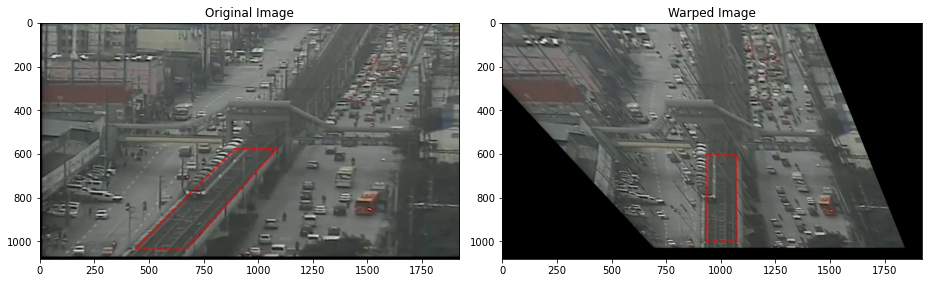

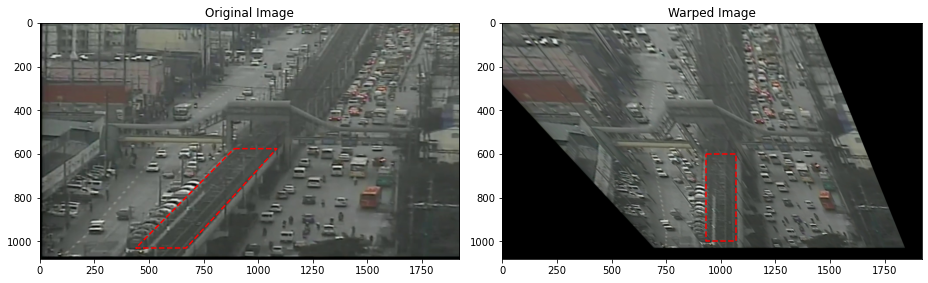

In [8]:
transformed = project_planes(traffic_frame10, 
                             area_of_interest, area_of_projection)
plot_project_planes(traffic_frame10, transformed, 
                            area_of_interest, area_of_projection)

transformed = project_planes(traffic_frame12, 
                             area_of_interest, area_of_projection)
plot_project_planes(traffic_frame12, transformed, 
                            area_of_interest, area_of_projection)

We can see that by applying the homography matrix, the objects at the backside of the image are now comparatively the same scale as the objects at the image’s front side.

Now, let’s apply image differencing! This can be computed by taking the difference between two aligned images. Note these images should be in the grayscale format for more straightforward analysis.

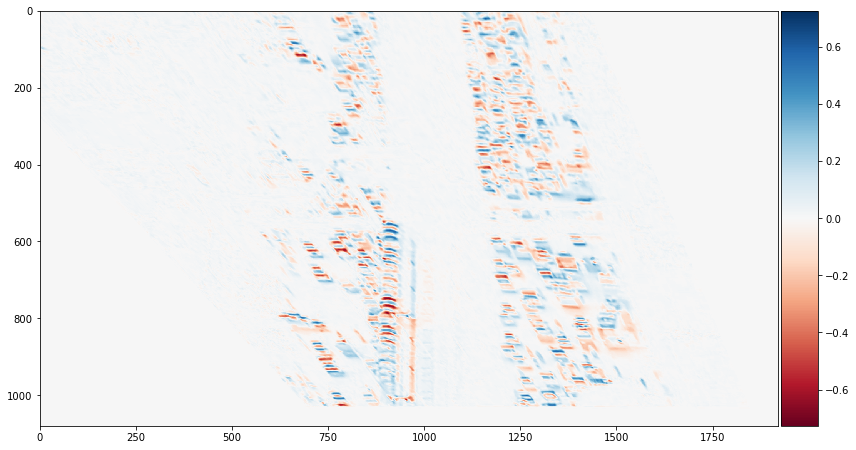

In [9]:
plt.figure(figsize=(12,12))
diff = (project_planes(traffic_frame10_gray) - 
        project_planes(traffic_frame12_gray))
imshow(diff)

By taking the difference between the two frames of the video, we can *see all the changes within that period*. Notice that the image shows the train on the tracks and the vehicles on the highways. These are all of the objects that moved! Moreover, notice how the roads, buildings, and pedestrian overpass are not reflected on the differenced image — this is because no changes happened on these objects!

Notice that the objects on the right side of the highway have red specks on top of the blue specks. Meanwhile, on the left side of the highway, the red specks are below the blue specks. This is because the initial position of the object is reflected as blue specks in the resulting image. Meanwhile, the final position is reflected as red specks.

Now, let’s see how far the object went from its initial to its final position. To do this, let’s get the absolute difference of the image so that the object in its initial and final position looks the same.

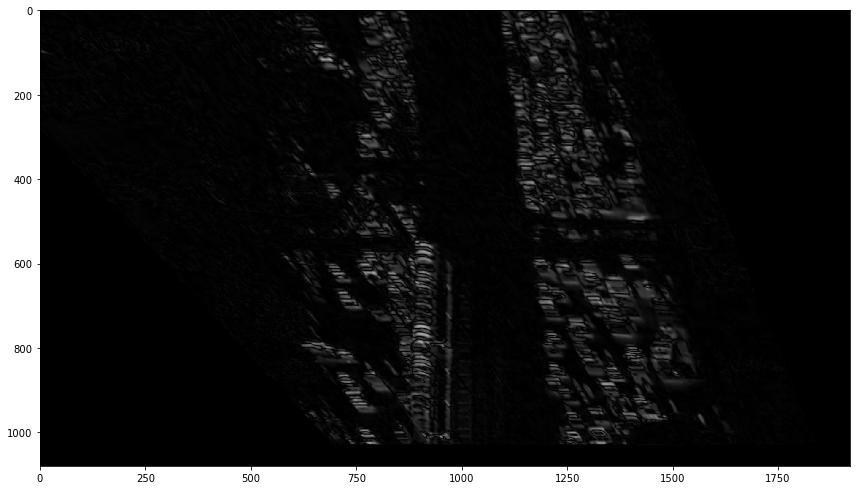

In [10]:
plt.figure(figsize=(12,12))
absdiff = abs(diff)
imshow(absdiff)

Great! Now, let’s use the template matching algorithm to detect these objects. Again, I will no longer discuss how template matching works. If you are not yet familiar with this technique, I suggest reading it in my previous article!

Let’s use the train as the object!

In [11]:
def find_template(image, x, y, x_width, y_width):
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    
    template = image[y:y+y_width, x:x+x_width]
    ax[0].imshow(template, cmap='gray')
    ax[0].set_title('Object Template')
    result = match_template(image, template)
    ax[1].imshow(result, cmap='viridis');
    ax[1].set_title('Cross-correlation image')
    
    coor_x, coor_y = np.unravel_index(np.argmax(result), result.shape)
    
    return coor_x, coor_y, template, result

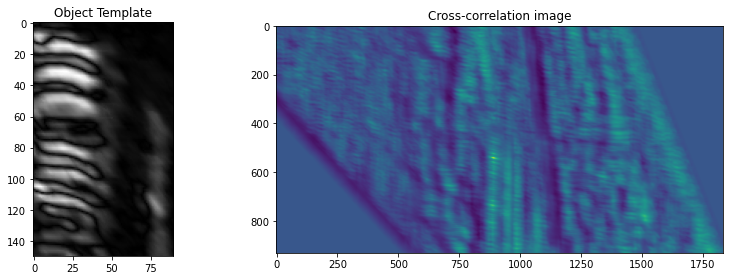

In [12]:
x, y, template, result = find_template(absdiff, 
                                       x=890, y=540, 
                                       x_width=90, 
                                       y_width=150)
plt.tight_layout()

Text(994, 887, 'Distance travelled is: 194 units')

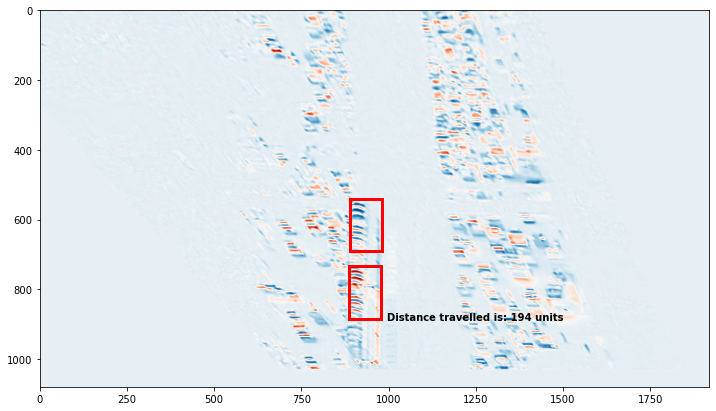

In [13]:
plt.figure(figsize=(12,12))

plt.imshow(diff, cmap='RdBu')
template_width, template_height = template.shape
for x, y in peak_local_max(result, threshold_abs=0.6):
    rect = plt.Rectangle((y, x), 
                         template_height, 
                         template_width, 
                         linewidth=3,
                         color='r', 
                         fc='none')
    plt.gca().add_patch(rect);
    
dist = np.diff([val[0] for val in 
                peak_local_max(result, threshold_abs=0.6)])[0]   
plt.text(x+260, y, 
         'Distance travelled is: {} units'.format(dist), 
         weight='bold', fontsize=10)

By using object detection, we were able to pinpoint where the object’s initial and final positions are in the image! We can now compute the distance traveled by the train by getting the difference between the coordinates of the initial and final position!

Moreover, we know that the time interval between the initial and final position, we can also compute for the train’s speed! Amazing, *right?*

#### In summary

We have explored how to use image differencing to detect changes and movement of objects in video feeds. We have also applied image processing techniques such as homography matrix and template matching to enhance our analysis of this problem further.

I hope you were able to appreciate the potential of image differencing in solving real-world problems. Stay tuned for more posts!